In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# I. Pen-and-paper

Valores da pdf das normais originais nos pontos dados

In [2]:
import numpy as np
from scipy import stats

normal1 = ((1, 1), np.array([[2, 0.5], [0.5, 2]]))
normal2 = ((0, 0), np.array([[1.5, 1], [1, 1.5]]))

observations = [(0.6, 0.1),
                (-0.4, 0.8),
                (0.2, 0.5),
                (0.4, -0.1)]

for index, (mean, cov) in enumerate((normal1, normal2)):
    multnorm = stats.multivariate_normal(mean, cov)

    print(f'Normal {index + 1}:')
    for point in observations:
        print(f'\t{point}:', round(multnorm.pdf(point), 5))

Normal 1:
	(0.6, 0.1): 0.06658
	(-0.4, 0.8): 0.05005
	(0.2, 0.5): 0.06837
	(0.4, -0.1): 0.05905
Normal 2:
	(0.6, 0.1): 0.11962
	(-0.4, 0.8): 0.06819
	(0.2, 0.5): 0.12958
	(0.4, -0.1): 0.1245


Cálculo da cov1 atualizada

In [3]:
a = 0.19263
X1 = np.array([[0.57348], [-0.40711]])
b = 0.63135
X2 = np.array([[-0.42652], [0.29289]])
c = 0.55176
X3 = np.array([[0.17348], [-0.00711]])
d = 0.16895
X4 = np.array([[0.37348], [-0.60711]])

cov1 = (1 / 1.54469) * (a * np.multiply(X1, X1.T) + b * np.multiply(X2, X2.T) + c * np.multiply(X3, X3.T) + d * np.multiply(X4, X4.T))
print(cov1)

[[ 0.1413737  -0.10541436]
 [-0.10541436  0.09606213]]


Cálculo da cov2 atualizada

In [4]:
a = 0.80737
X1 = np.array([[0.29086], [-0.11043]])
b = 0.36865
X2 = np.array([[-0.70914], [0.58957]])
c = 0.44824
X3 = np.array([[-0.10914], [0.28957]])
d = 0.83105
X4 = np.array([[0.09086], [-0.31043]])

cov2 = (1 / 2.45531) * (a * np.multiply(X1, X1.T) + b * np.multiply(X2, X2.T) + c * np.multiply(X3, X3.T) + d * np.multiply(X4, X4.T))
print(cov2)

[[ 0.10829169 -0.08865146]
 [-0.08865146  0.10412399]]


Valores da pdf das normais atualizadas nos pontos dados

In [5]:
points = [(0.6, 0.1), (-0.4, 0.8), (0.2, 0.5), (0.4, -0.1)]

for point in points:
    print(f'Point {point}')

    multnorm = stats.multivariate_normal(np.array([0.02652, 0.50711]), cov1)
    print('\tNormal 1:', round(multnorm.pdf(np.array(point)), 5))

    multnorm = stats.multivariate_normal(np.array([0.30914, 0.21043]), cov2)
    print('\tNormal 2:', round(multnorm.pdf(np.array(point)), 5))

Point (0.6, 0.1)
	Normal 1: 0.98907
	Normal 2: 1.42292
Point (-0.4, 0.8)
	Normal 1: 1.65318
	Normal 2: 0.26673
Point (0.2, 0.5)
	Normal 1: 1.87731
	Normal 2: 1.36526
Point (0.4, -0.1)
	Normal 1: 0.08877
	Normal 2: 1.08387


<hr>

# II. Programming and critical analysis

Recall the column_diagnosis.arff dataset from previous homeworks. For the following exercises, 
normalize the data using sklearn's MinMaxScaler.

1) **[4v] Using sklearn, apply k-means clustering fully unsupervisedly on the normalized data with 
k ∈{2,3,4,5} (random=0 and remaining parameters as default). Assess the silhouette and purity of 
the produced solutions.**

In [6]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
from sklearn import metrics, cluster
from sklearn.preprocessing import MinMaxScaler

def purity_score(y_true, y_pred):
    # compute contingency/confusion matrix
    confusion_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')
X = df.drop('class', axis=1)
y = df['class']

X_scaled = MinMaxScaler().fit_transform(X)

for k in (2, 3, 4, 5):
    print("Clustering results with k =", k)

    kmeans_model = cluster.KMeans(n_clusters=k, random_state=0).fit(X_scaled)

    print("\tsilhouette:", round(metrics.silhouette_score(X_scaled, kmeans_model.labels_, metric='euclidean'), 5))
    print("\tpurity:", round(purity_score(y, kmeans_model.labels_), 5))

Clustering results with k = 2
	silhouette: 0.36044
	purity: 0.63226
Clustering results with k = 3
	silhouette: 0.29579
	purity: 0.66774
Clustering results with k = 4
	silhouette: 0.27442
	purity: 0.66129
Clustering results with k = 5
	silhouette: 0.23824
	purity: 0.67742


A *silhouette* indica o quão coesos e bem separados estão os clusters, tomando valores entre -1 e 1, sendo que 1 indica alta coesão e separação.
A pureza reflete o quão correctamente as observações estão agrupadas, tomando valores entre 0 e 1, sendo 1 a pureza máxima.<br>
Podemos observar que à medida que o número de clusters (k) aumenta, a *silhouette* diminui mas que a pureza se mantém essencialmente constante em torno de 66%. Este valor indica-nos que a maioria dos elementos de cada cluster pertence à mesma classe, apesar de não ser uma pureza realmente significativa, já que apenas se costumam considerar valores superiores a 70%.<br>
Dependendo do contexto, o critério de escolha do nº de clusters (k) difere:
- Se priorizarmos cluster bem separados, devemos olhar para o que apresenta melhor *silhouette*, neste caso k = 2;
- Se por outro lado a prioridade for preservar informação, no sentido de ter clusters que refletem as *ground truths*, devemos escolher o que apresenta melhor pureza, que neste caso é k = 5, apesar de não denotar uma grande diferença em relação aos outros modelos.

2) **[2v] Consider the application of PCA after the data normalization:  
i. Identify the variability explained by the top two principal components.  
ii. For each one of these two components, sort the input variables by relevance by 
inspecting the absolute weights of the linear projection.**

In [7]:
from sklearn.decomposition import PCA
from pprint import pprint

pca = PCA(n_components=2, svd_solver='full')
pca.fit(X_scaled)
print("1st component explained variance ratio:", round(pca.explained_variance_ratio_[0], 5))
print("2nd component explained variance ratio:", round(pca.explained_variance_ratio_[1], 5))
print()

columns = X.columns.to_list()
for i in range(len(pca.components_)):
    impt_features = {columns[j] : abs(pca.components_[i][j]) for j in range(len(columns))}
    print(f"Features by importance on {'1st' if i == 0 else '2nd'} component:")
    pprint([(round(value[0], 5), value[1]) for value in sorted(zip(impt_features.values(), impt_features.keys()), reverse=True)])

1st component explained variance ratio: 0.56181
2nd component explained variance ratio: 0.20956

Features by importance on 1st component:
[(0.59162, 'pelvic_incidence'),
 (0.51508, 'lumbar_lordosis_angle'),
 (0.46704, 'pelvic_tilt'),
 (0.32569, 'sacral_slope'),
 (0.21693, 'degree_spondylolisthesis'),
 (0.11582, 'pelvic_radius')]
Features by importance on 2nd component:
[(0.67037, 'pelvic_tilt'),
 (0.58107, 'pelvic_radius'),
 (0.4433, 'sacral_slope'),
 (0.10004, 'pelvic_incidence'),
 (0.08005, 'lumbar_lordosis_angle'),
 (0.00458, 'degree_spondylolisthesis')]


3) **[2v] Visualize side-by-side the data using: i) the ground diagnoses, and ii) the previously learned 
k =3 clustering solution. To this end, projected the normalized data onto a 2-dimensional data 
space using PCA and then color observations using the reference and cluster annotations.**

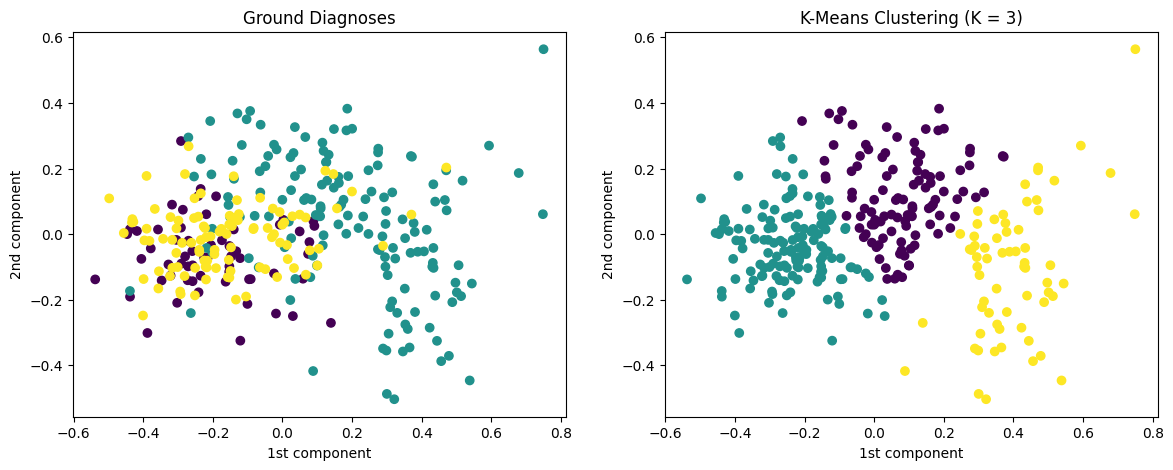

In [8]:
import matplotlib.pyplot as plt

X_pca = pca.transform(X_scaled)
kmeans_model = cluster.KMeans(n_clusters=3, random_state=0).fit(X_pca)

classes = ('Hernia', 'Spondylolisthesis', 'Normal')
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[classes.index(label) for label in y])
plt.title("Ground Diagnoses")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_model.labels_)
plt.title("K-Means Clustering (K = 3)")
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.show()

4) **[1v] Considering the results from questions (1) and (3), identify two ways on how clustering can 
be used to characterize the population of ill and healthy individuals.**

1. Se a pureza do modelo for alta, é possível essencialmente fazer um mapeamento direto entre cada cluster e um diagnóstico, já que em cada cluster grande parte das observações pertencem à mesma classe. Podemos assim fazer *hard-assign* das observações e, com base no cluster resultante, caracterizá-la, isto é, atribuir um diagnóstico.<br>
2. Caso não se obtenha tal pureza, podemos recorrer a uma redução de dimensionalidade (através do PCA) e com base nas novas features, que à partida contam com menos ruído, concluir um diagnóstico através da separação e distribuição dos pontos no gráfico. Desta forma, é possível obter melhores resultados quando a *silhouette* é alta, já que existe uma grande coesão (baixa distância intra-cluster) e elevada separação (distância inter-cluster).